
> **Install Required Packages**



In [ ]:
import json
import os
kaggle_username = "suruthikacd"
kaggle_key = "xxxxxxxxxxxxxxxxxxxxxxxx"
os.makedirs("/root/.kaggle", exist_ok=True)
kaggle_data = {
    "username": kaggle_username,
    "key": kaggle_key
}
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_data, f)
!chmod 600 /root/.kaggle/kaggle.json

print("kaggle.json created successfully!")



kaggle.json created successfully!


In [ ]:
!kaggle datasets download -d vbookshelf/respiratory-sound-database


Dataset URL: https://www.kaggle.com/datasets/vbookshelf/respiratory-sound-database
License(s): unknown
100% 3.68G/3.69G [00:41<00:00, 36.7MB/s]
100% 3.69G/3.69G [00:41<00:00, 94.8MB/s]


In [ ]:
!unzip -o respiratory-sound-database.zip -d /content/respiratory-sound-database


Archive:  respiratory-sound-database.zip
  inflating: /content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt  
  inflating: /content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav  
  inflating: /content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt  
  inflating: /content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav  
  inflating: /content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt  
  inflating: /content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav  
  inflating: /content/respiratory-sound-databas

In [ ]:
!pip install librosa soundfile tensorflow matplotlib seaborn scikit-learn --quiet

> Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

> SET CORRECT DATA PATHS

In [ ]:
AUDIO_PARENT_DIR = '/content/drive/MyDrive/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
DIAG_CSV = '/content/drive/MyDrive/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv'

SAMPLE_RATE = 44100
DURATION = 3.0
OFFSET = 0.5
N_MFCC = 40

OUTPUT_DIR = "phase4_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

> Load Metadata

In [ ]:
AUDIO_PARENT_DIR = '/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
DIAG_CSV = '/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv'

diag_df = pd.read_csv(DIAG_CSV, header=None, names=['patient_id', 'diagnosis'])
patient_diag = dict(zip(diag_df['patient_id'], diag_df['diagnosis']))

filepaths = []
labels = []
patients = []

for fn in os.listdir(AUDIO_PARENT_DIR):
    if fn.endswith(".wav"):
        fp = os.path.join(AUDIO_PARENT_DIR, fn)
        filepaths.append(fp)

        pid = int(fn.split('_')[0])
        patients.append(pid)

        labels.append(patient_diag.get(pid, "unknown"))

meta = pd.DataFrame({
    "filepath": filepaths,
    "patient": patients,
    "label": labels
})
meta = meta[meta["label"] != "unknown"].reset_index(drop=True)

meta.head()

,filepath,patient,label
0,/content/respiratory-sound-database/Respirator...,200,COPD
1,/content/respiratory-sound-database/Respirator...,118,COPD
2,/content/respiratory-sound-database/Respirator...,172,COPD
3,/content/respiratory-sound-database/Respirator...,203,COPD
4,/content/respiratory-sound-database/Respirator...,121,Healthy


> Patient-Level Train/Val/Test Split

In [ ]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(meta, groups=meta["patient"]))

train_meta = meta.iloc[train_idx].reset_index(drop=True)
test_meta  = meta.iloc[test_idx].reset_index(drop=True)
train_meta, val_meta = train_test_split(
    train_meta,
    test_size=0.15,
    random_state=42
)

len(train_meta), len(val_meta), len(test_meta)

(600, 106, 214)



> MFCC Extraction Function



In [ ]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION, offset=OFFSET)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    return np.mean(mfcc.T, axis=0)




> Build Train/Val/Test Feature Arrays



In [ ]:
import time
import pickle

def extract_features_fast(file_path):

    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION, offset=OFFSET)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    return np.mean(mfcc.T, axis=0)


def extract_split_features(df):
    features = []
    start_time = time.time()

    for i, fp in enumerate(df["filepath"]):
        feat = extract_features_fast(fp)
        features.append(feat)

        if i % 50 == 0:
            print(f"Extracted {i}/{len(df)} MFCCs...")

    print("DONE. Time taken:", time.time() - start_time, "seconds")
    return np.array(features)


print("Extracting TRAIN MFCCs...")
X_train = extract_split_features(train_meta)

print("Extracting VAL MFCCs...")
X_val = extract_split_features(val_meta)

print("Extracting TEST MFCCs...")
X_test = extract_split_features(test_meta)
le = LabelEncoder()
y_train = le.fit_transform(train_meta["label"])
y_val   = le.transform(val_meta["label"])
y_test  = le.transform(test_meta["label"])

# Save the LabelEncoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

y_train_cat = tf.keras.utils.to_categorical(y_train)
y_val_cat   = tf.keras.utils.to_categorical(y_val)
y_test_cat  = tf.keras.utils.to_categorical(y_test)

Extracting TRAIN MFCCs...
Extracted 0/600 MFCCs...
Extracted 50/600 MFCCs...
Extracted 100/600 MFCCs...
Extracted 150/600 MFCCs...
Extracted 200/600 MFCCs...
Extracted 250/600 MFCCs...
Extracted 300/600 MFCCs...
Extracted 350/600 MFCCs...
Extracted 400/600 MFCCs...
Extracted 450/600 MFCCs...
Extracted 500/600 MFCCs...
Extracted 550/600 MFCCs...
DONE. Time taken: 47.33831572532654 seconds
Extracting VAL MFCCs...
Extracted 0/106 MFCCs...
Extracted 50/106 MFCCs...
Extracted 100/106 MFCCs...
DONE. Time taken: 2.374973773956299 seconds
Extracting TEST MFCCs...
Extracted 0/214 MFCCs...
Extracted 50/214 MFCCs...
Extracted 100/214 MFCCs...
Extracted 150/214 MFCCs...
Extracted 200/214 MFCCs...
DONE. Time taken: 6.34081768989563 seconds



> Build CNN Model



In [ ]:
model = models.Sequential([
    layers.Reshape((40,1), input_shape=(40,)),
    layers.Conv1D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 40, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 38, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 36, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,800 (1.23 MB)

 Trainable params: 321,416 (1.23 MB)

 Non-trainable params: 384 (1.50 KB)



> Train Model



In [ ]:
cb = [
    callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True),
    callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
]

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=70,
    batch_size=32,
    callbacks=cb
)

Epoch 1/70
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6913 - loss: 1.4360

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.7062 - loss: 1.3713 - val_accuracy: 0.1132 - val_loss: 2.0138
Epoch 2/70
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7985 - loss: 0.6654

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8030 - loss: 0.6525 - val_accuracy: 0.3962 - val_loss: 1.3633
Epoch 3/70
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8034 - loss: 0.5582

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8069 - loss: 0.5504 - val_accuracy: 0.7547 - val_loss: 1.0427
Epoch 4/70
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8605 - loss: 0.3829

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8613 - loss: 0.3835 - val_accuracy: 0.7264 - val_loss: 0.9178
Epoch 5/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8791 - loss: 0.3877 - val_accuracy: 0.8679 - val_loss: 0.9764
Epoch 6/70
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8827 - loss: 0.3358

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8818 - loss: 0.3397 - val_accuracy: 0.8491 - val_loss: 0.6493
Epoch 7/70
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8684 - loss: 0.3342

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8696 - loss: 0.3345 - val_accuracy: 0.8585 - val_loss: 0.5814
Epoch 8/70
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8853 - loss: 0.3366

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8852 - loss: 0.3348 - val_accuracy: 0.8491 - val_loss: 0.5324
Epoch 9/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9024 - loss: 0.2703 - val_accuracy: 0.8019 - val_loss: 0.6135
Epoch 10/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8829 - loss: 0.3288

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8832 - loss: 0.3272 - val_accuracy: 0.8585 - val_loss: 0.4214
Epoch 11/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8988 - loss: 0.2774 - val_accuracy: 0.8491 - val_loss: 0.4494
Epoch 12/70
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8952 - loss: 0.2571

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8935 - loss: 0.2645 - val_accuracy: 0.8868 - val_loss: 0.4117
Epoch 13/70
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9042 - loss: 0.2575

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9034 - loss: 0.2605 - val_accuracy: 0.8679 - val_loss: 0.4112
Epoch 14/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9023 - loss: 0.2673 - val_accuracy: 0.8585 - val_loss: 0.4498
Epoch 15/70
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8821 - loss: 0.2930

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8829 - loss: 0.2924 - val_accuracy: 0.8868 - val_loss: 0.4056
Epoch 16/70
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9123 - loss: 0.2217

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9125 - loss: 0.2250 - val_accuracy: 0.8774 - val_loss: 0.3776
Epoch 17/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8859 - loss: 0.2706 - val_accuracy: 0.8491 - val_loss: 0.4724
Epoch 18/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9054 - loss: 0.2398 - val_accuracy: 0.8868 - val_loss: 0.4409
Epoch 19/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8902 - loss: 0.2384 - val_accuracy: 0.8774 - val_loss: 0.4532
Epoch 20/70
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9208 - loss: 0.2104 - val_accuracy: 0.8774 - val_loss: 0.4220




> Plot Accuracy & Loss Curves



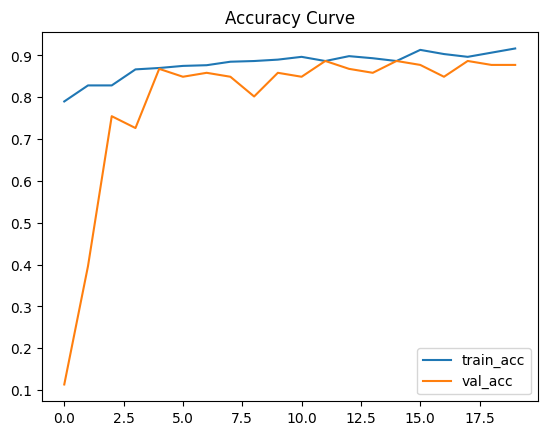

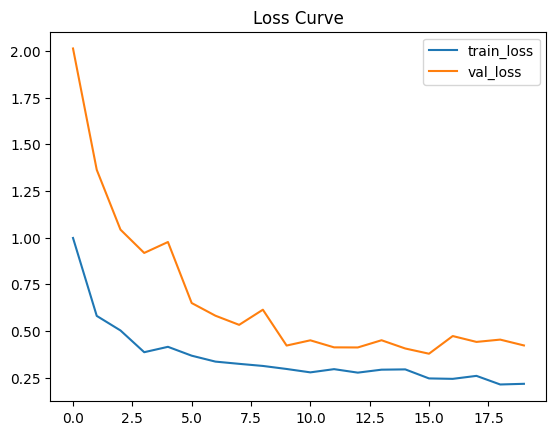

In [ ]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title("Accuracy Curve")
plt.savefig(f"{OUTPUT_DIR}/accuracy_curve.png")
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Loss Curve")
plt.savefig(f"{OUTPUT_DIR}/loss_curve.png")
plt.show()



> Evaluate Test Performance



In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print("Test Accuracy:", test_acc)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9344 - loss: 0.3108 
Test Accuracy: 0.9299065470695496




> Confusion Matrix + Classification Report



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
                precision    recall  f1-score   support

Bronchiectasis       0.50      0.33      0.40         3
          COPD       0.99      0.97      0.98       201
       Healthy       0.17      0.25      0.20         4
          URTI       1.00      0.33      0.50         6

     micro avg       0.97      0.93      0.95       214
     macro avg       0.67      0.47      0.52       214
  weighted avg       0.97      0.93      0.95       214



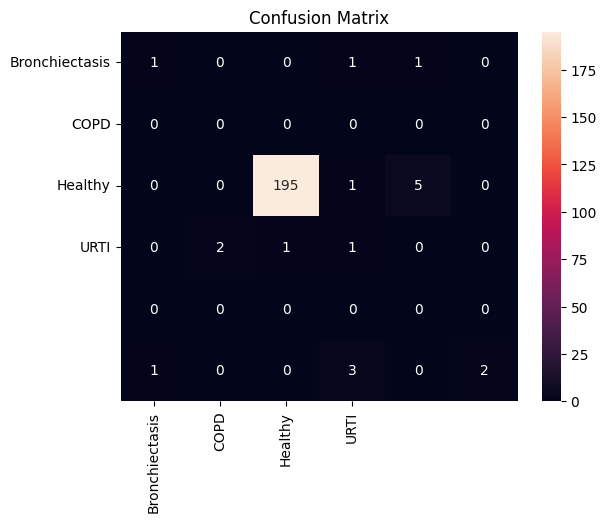

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
test_classes = np.unique(y_test)
report = classification_report(
    y_test,
    y_pred,
    labels=test_classes,
    target_names=le.classes_[test_classes]
)

print(report)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=le.classes_[test_classes],
    yticklabels=le.classes_[test_classes]
)
plt.title("Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")
plt.show()




> Predicted Confidence and Output



In [ ]:
pred_table = pd.DataFrame({
    "Filepath": test_meta["filepath"],
    "True Label": le.inverse_transform(y_test),
    "Predicted Label": le.inverse_transform(y_pred),
    "Confidence": np.max(model.predict(X_test), axis=1)
})
pred_table.style.background_gradient(cmap="RdBu_r")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


,Filepath,True Label,Predicted Label,Confidence
0,/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/178_2b2_Ar_mc_AKGC417L.wav,COPD,COPD,0.991882
1,/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/112_1b1_Ar_sc_Meditron.wav,COPD,COPD,0.890964
2,/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/168_1b1_Al_sc_Meditron.wav,Bronchiectasis,Pneumonia,0.263592
3,/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/178_1b2_Ar_mc_AKGC417L.wav,COPD,COPD,0.980961
4,/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/178_1b2_Al_mc_AKGC417L.wav,COPD,COPD,0.986330
5,/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav,URTI,URTI,0.292551
6,/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/178_2b2_Lr_mc_AKGC417L.wav,COPD,COPD,0.964986
7,/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/156_2b3_Ar_mc_AKGC417L.wav,COPD,COPD,0.446172
8,/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/177_1b2_Tc_mc_AKGC417L.wav,COPD,COPD,0.999803
9,/content/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/154_2b4_Ll_mc_AKGC417L.wav,COPD,COPD,0.970002



> Save MFCC & Spectrogram Examples


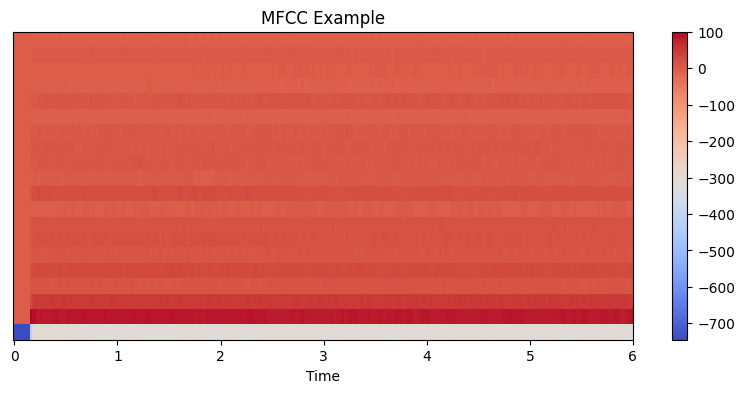

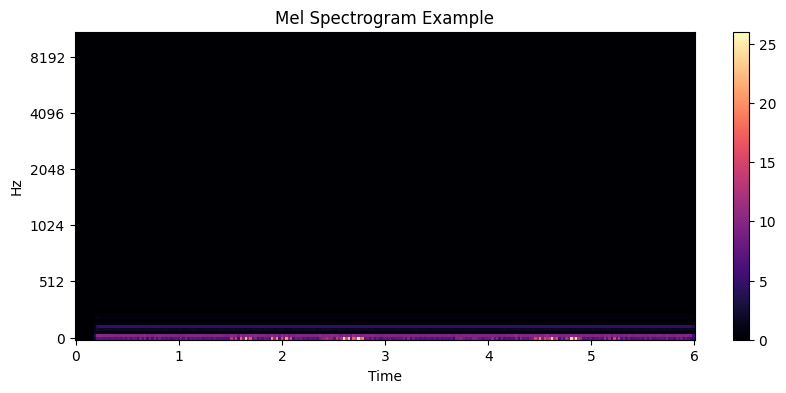

In [ ]:
example_file = train_meta["filepath"].iloc[0]
y, sr = librosa.load(example_file, sr=SAMPLE_RATE, duration=DURATION)

plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.feature.mfcc(y=y, sr=sr), x_axis='time')
plt.title("MFCC Example")
plt.colorbar()
plt.savefig(f"{OUTPUT_DIR}/example_mfcc.png")
plt.show()

plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.feature.melspectrogram(y=y, sr=sr), x_axis='time', y_axis='mel')
plt.title("Mel Spectrogram Example")
plt.colorbar()
plt.savefig(f"{OUTPUT_DIR}/example_spectrogram.png")
plt.show()


In [ ]:
import gradio as gr
import librosa
import numpy as np
import tensorflow as tf
import pickle
model = tf.keras.models.load_model("best_model.h5")

# Load Label Encoder
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

class_names = le.classes_
def predict_lung_sound(audio_file):
    if audio_file is None:
        return "No audio uploaded."

    try:
        audio, sr = librosa.load(audio_file, duration=3)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        mfcc_scaled = np.mean(mfcc.T, axis=0)
        features = mfcc_scaled.reshape(1, -1)

        pred = model.predict(features)
        pred_class = np.argmax(pred)

        return f"Predicted: **{class_names[pred_class]}**"

    except Exception as e:
        return f"❌ Error: {str(e)}"
css = """
    body {
        background-color: #000000 !important;
    }
    .gradio-container {
        background-color: #000000 !important;
        color: #ffffff !important;
    }
    h1 {
        text-align:center;
        color:#00eaff !important;
        font-weight:900;
        font-size: 36px;
    }
    .prediction-box {
        border: 2px solid #00ff99;
        padding: 15px;
        border-radius: 12px;
        background: #001a0f;
        font-size: 22px;
        font-weight: bold;
        color: #00ffcc;
        text-align: center;
    }
    .gr-button {
        background: #00bcd4 !important;
        color:white !important;
        border-radius: 10px !important;
        font-weight: bold !important;
        border: 1px solid #00eaff !important;
    }
    .gr-button:hover {
        background: #0097a7 !important;
    }
"""

with gr.Blocks(css=css, theme=gr.themes.Soft()) as demo:

    gr.Markdown("<h1>🩺 Lung Sound Classifier — AI Diagnosis</h1>")
    gr.Markdown(
        "<p style='text-align:center; font-size:18px; color:#cccccc;'>"
        "Upload a lung sound file (.wav / .mp3). The AI will classify it as Crackle, Wheeze, Normal,Bronchiectasis,or Both."
        "</p>"
    )

    with gr.Row():
        audio_input = gr.Audio(type="filepath", label="⬆️ Upload Lung Sound", interactive=True)

    predict_btn = gr.Button("🔬 Predict Lung Condition")

    output_box = gr.Markdown("", elem_classes="prediction-box")

    predict_btn.click(fn=predict_lung_sound, inputs=[audio_input], outputs=[output_box])

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5b7455ef48f1bb72ef.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
